Weakly coupled Co-simulation
================

This guides shows how to implement a simplified weakly-coupled co-simulation in DPsim

Test circuit
--------------------

As a first simple, test we will simulate a small static network. The network consists of 4 nodes and 4 elements:

| Component | Type              | Python Class                              | Node A | Node B | Paramter |
| :---------| :----             | :---------------------------------------- | :----- | :----- | :------- |
| r_1       | Source resistance | `dpsimpy.dp.ph1.Resistor`                 | 0      | GND    | 0.1 Ohm  |
| c_1       | Line capacitance  | `dpsimpy.dp.ph1.Capacitor`                | 0      | GND    | 1 Farad  |
| c_2       | Line capacitance  | `dpsimpy.dp.ph1.Capacitor`                | 1      | GND    | 1 Farad  |
| r_line    | Line resistance   | `dpsimpy.dp.ph1.Resistor`                 | 1      | 0      | 0.1 Ohm  |
| r_load    | Load              | `dpsimpy.dp.ph1.Resistor`                 | 1      | GND    | 1 Ohm    |

Before we can start, we must import the DPsim Python module.
We also add `dp` as an alias for the dynamic phasor components.

In [8]:
import dpsimpy

Next, we can define the model by creating a couple of components.
Each component is identified by a name which is passed as the first argument.
Following arguments are used to define the topology by assigning the component to a specific node / bus or to pass parameters.

In [9]:
# Nodes
gnd = dpsimpy.dp.SimNode.gnd
n0  = dpsimpy.dp.SimNode("n0")
n1  = dpsimpy.dp.SimNode("n1")

r_1 = dpsimpy.dp.ph1.Resistor("r_1")
r_1.R = 0.1
r_line = dpsimpy.dp.ph1.Resistor("r_line")
r_line.R = 0.1
c_1 = dpsimpy.dp.ph1.Capacitor("c_1")
c_1.C = 1
c_2 = dpsimpy.dp.ph1.Capacitor("c_2")
c_2.C = 1
r_load = dpsimpy.dp.ph1.Resistor("r_load")
r_load.R = 1

# Initial conditions
n0.set_initial_voltage(5)
n1.set_initial_voltage(2)

# Connections 
r_1.connect([n0, gnd])
r_line.connect([n0, n1])
c_1.connect([n0, gnd])
c_2.connect([n1, gnd])
r_load.connect([n1, gnd])

Next, we have to create a simulation object:

In [10]:
sys = dpsimpy.SystemTopology(50, [ n0, n1 ], [ r_1, r_line, c_1, c_2, r_load ])

We can also visualize the system topology:

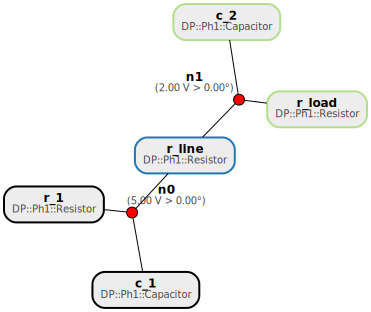

In [11]:
sys

Finally, we can start the simulation and wait for its completion:

In [12]:
sim = dpsimpy.Simulation("WeaklyCoupledCosim", loglevel=dpsimpy.LogLevel.debug)
sim.set_system(sys)
sim.set_time_step(1e-3)
sim.set_final_time(1.0)

log = dpsimpy.Logger("WeaklyCoupledCosim")
for i in range(0, len(sys.nodes)):
    log.log_attribute("v" + str(i), "v", sys.nodes[i])

sim.add_logger(log)
    
sim.run()

[15:39:30.578825 WeaklyCoupledCosim info] Initialize simulation: WeaklyCoupledCosim
[15:39:30.579027 MnaSolverFactory info] creating EigenDense solver implementation
[15:39:30.580037 WeaklyCoupledCosim info] Scheduling tasks.
[15:39:30.580491 WeaklyCoupledCosim info] Scheduling done.
[15:39:30.580495 WeaklyCoupledCosim info] Opening interfaces.
[15:39:30.580496 WeaklyCoupledCosim info] Start synchronization with remotes on interfaces
[15:39:30.580498 WeaklyCoupledCosim info] Synchronized simulation start with remotes
[15:39:30.580500 WeaklyCoupledCosim info] Start simulation: WeaklyCoupledCosim
[15:39:30.580504 WeaklyCoupledCosim info] Time step: 1.000000e-03
[15:39:30.580507 WeaklyCoupledCosim info] Final time: 1.000000e+00
[15:39:30.611497 WeaklyCoupledCosim info] Simulation calculation time: 0.030977
[15:39:30.611581 WeaklyCoupledCosim info] Simulation finished.


Results can be analyzed and plotted by the `villas.dataprocessing` package:

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}

import matplotlib.pyplot as plt
import villas.dataprocessing.plottools as pt
import villas.dataprocessing.readtools as rt
import villas.dataprocessing.timeseries as ts

results = rt.read_timeseries_dpsim('logs/WeaklyCoupledCosim.csv')

results_emt = []
for series in results:
    results_emt.append(results[series].frequency_shift(freq=50))

results_emt = [ results[series].frequency_shift(freq=50) for series in results ]

results_strongly_coupled0 = rt.read_timeseries_dpsim('../../logs/WeaklyCoupledCosim0/WeaklyCoupledCosim0.csv')
results_strongly_coupled0_emt = [ results[series].frequency_shift(freq=50) for series in results ]

for series in results_emt:
    pt.plot_timeseries('Results EMT', series)

for series in results_strongly_coupled0_emt:
    pt.plot_timeseries('Results EMT', series, '--')

plt.grid()
plt.show()

column number: 2
results length: 1000
real column names: []
complex column names: ['v0', 'v1']


EmptyDataError: No columns to parse from file

In [14]:
!cat logs/Example1_Solver.log

515.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[I] ---- Start initialization ----
[I] -- Process topology
[I] Added DP::Ph1::VoltageSource 'v_s' to simulation.
[I] Added DP::Ph1::Resistor 'r_line' to simulation.
[I] Added DP::Ph1::Inductor 'l_line' to simulation.
[I] Added DP::Ph1::Resistor 'r_load' to simulation.
[I] Added node n0
[I] Added node n1
[I] Added node n2
[I] Collected virtual node 2 of 0
[I] Created virtual nodes:
[I] Number of network nodes: 3
[I] Number of network and virtual nodes: 4
[I] Assigned index 0 to phase A of node 0
[I] Assigned index 1 to phase A of node 1
[I] Assigned index 2 to phase A of node 2
[I] Assigned index 3 to phase A of node 3
[I] Assigned simulation nodes to topology nodes:
[I] Number of network simulation nodes: 3
[I] Number of simulation nodes: 4
[I] Number of harmonic simulation nodes: 0
[I] -- Create empty MNA system matrices and vectors
[I] -- Initialize components from power flow
[I] -- Initialize MNA properties of components
[I] -- Initialize MNA system matrices and source vector
[I] --